In [263]:
import sys
sys.path.insert(0,'C:\\Users\\nakaa1\\code\\PsychRNN')
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN/')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

# from brian2 import *

<module 'psychrnn' from 'C:\\Users\\nakaa1\\code\\PsychRNN\\psychrnn\\__init__.py'>

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [461]:
dt = 1 # time-step
tau = 10 # intrinsic time constant of neural state decay
T = 50 # time to run for (number of steps is T/dt)
N_batch = 300 # number of trials per training step
N_rec = 200 # number of recurrent units
name = 'basicModel'
N_in = 80
N_out = 80

In [462]:
from psychrnn.tasks.task import Task

def gaussian_input(N_in, mu = 0, sigma = 1):
    y = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (np.arange(N_in) - mu)**2 / (2 * sigma**2)))
    y = y/np.max(y)
    return y

"""
Binary Decision task. 
Takes two channels of noisy input.
Binary output with a one hot encoding towards the higher mean channel
"""

class noisy_decode(Task):
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(noisy_decode,self).__init__(N_in, N_out, dt, tau, T, N_batch)
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.6 + T * 0.1
        params['duration'] = 40
        params['mu'] = np.random.randint(self.N_in)
        params['sigma'] = np.random.choice([1,2,3,4,5,6,7,8])
        params['neuron_noise'] = 4
        params['baseline_rate'] = 2
        params['peak_rate'] = np.random.choice(40)+1
        true_rates = gaussian_input(N_in = N_in,
                                              mu = params['mu'],
                                              sigma = params['sigma']) * params['peak_rate']
        true_rates[true_rates<0.01] = 0
        params['true_rates'] = true_rates.copy()
        
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) + params['baseline_rate'] + np.random.randn(self.N_in)*params['neuron_noise']
        y_t = np.zeros(self.N_out) + params['baseline_rate'] 
        mask_t = np.ones(self.N_out) 

        
        if (t>params['onset']) and (t<(params['onset']+params['duration'])):
            y_t += params['true_rates']
            x_t += params['true_rates']  
            
        x_t[x_t<0] = 0

        
        
        return x_t, y_t, mask_t


In [463]:
swv = noisy_decode(N_in = N_in, N_out = N_out,dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()

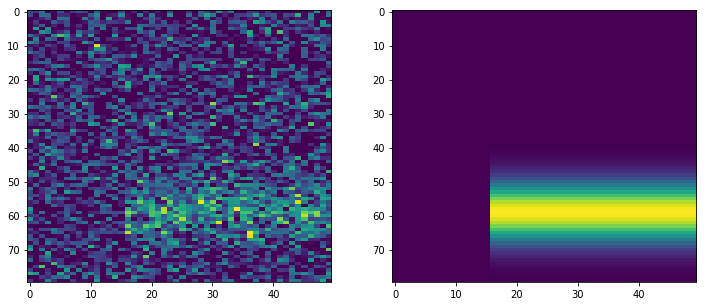

In [464]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].imshow(x[0,:,:].T,aspect = 'auto')
ax[1].imshow(y[0,:,:].T,aspect = 'auto')

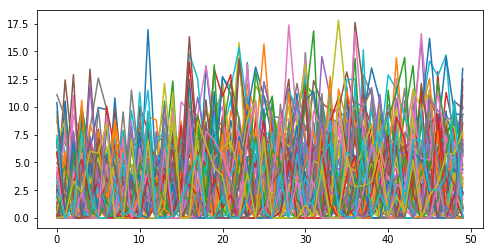

In [465]:
f,ax = plt.subplots(figsize = (8,4))
ax.plot(x[0,:,:]);
# ax.set_xlim((0,50))

In [466]:
params = swv.__dict__
print(params)

{'N_batch': 300, 'N_in': 80, 'N_out': 80, 'dt': 1, 'tau': 10, 'T': 50, 'alpha': 0.1, 'N_steps': 50}


There are some other optional parameters we can add in:

In [467]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec
params['dale_ratio'] = 0.7 # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.01 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None
params['L2_out'] = 0
params['L2_rec'] = 0
params['L2_firing_rate_reg'] = 0
params['L1_out'] = 0
params['L1_in'] = 0
params['L1_rec'] = 0

In [468]:
try:
    basicModel.destruct()
except:
    pass
basicModel = Basic(params)
basicModel.build()

In [469]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 250000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 250000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x28707fd8cf8>,
 'clip_grads': True}

In [470]:
basicModel.train(gen, train_params)

Iter 3000, Minibatch Loss= 50.369240
Iter 6000, Minibatch Loss= 37.966778
Iter 9000, Minibatch Loss= 38.129391
Iter 12000, Minibatch Loss= 39.702038
Iter 15000, Minibatch Loss= 30.375917
Iter 18000, Minibatch Loss= 27.743155
Iter 21000, Minibatch Loss= 27.885302
Iter 24000, Minibatch Loss= 23.065136
Iter 27000, Minibatch Loss= 24.228218
Iter 30000, Minibatch Loss= 28.240726
Training weights saved in file: None100
Iter 33000, Minibatch Loss= 24.884539
Iter 36000, Minibatch Loss= 24.381451
Iter 39000, Minibatch Loss= 25.079531
Iter 42000, Minibatch Loss= 21.775221
Iter 45000, Minibatch Loss= 24.602556
Iter 48000, Minibatch Loss= 21.264523
Iter 51000, Minibatch Loss= 21.437746
Iter 54000, Minibatch Loss= 21.456869
Iter 57000, Minibatch Loss= 19.666756
Iter 60000, Minibatch Loss= 19.162582
Training weights saved in file: None200
Iter 63000, Minibatch Loss= 17.595232
Iter 66000, Minibatch Loss= 18.672100
Iter 69000, Minibatch Loss= 17.256136
Iter 72000, Minibatch Loss= 19.966896
Iter 75000,

([50.36924,
  37.966778,
  38.12939,
  39.702038,
  30.375917,
  27.743155,
  27.885302,
  23.065136,
  24.228218,
  28.240726,
  24.884539,
  24.38145,
  25.07953,
  21.77522,
  24.602556,
  21.264523,
  21.437746,
  21.45687,
  19.666756,
  19.162582,
  17.595232,
  18.6721,
  17.256136,
  19.966896,
  15.59571,
  16.896402,
  13.853595,
  13.750498,
  14.086748,
  13.007197,
  12.456014,
  10.660742,
  11.114458,
  9.769022,
  10.334871,
  9.460151,
  9.3491125,
  10.003275,
  8.889487,
  8.794541,
  7.82846,
  9.256825,
  8.921005,
  8.221253,
  8.633977,
  7.842094,
  7.490005,
  7.4548807,
  7.6687384,
  8.464165,
  7.4995217,
  7.330963,
  7.3456116,
  7.653303,
  7.6342993,
  8.235138,
  7.869944,
  7.7026544,
  7.438568,
  7.9079766,
  7.14014,
  7.554335,
  7.767635,
  7.387038,
  8.021321,
  6.2603545,
  7.8434777,
  7.6932917,
  6.256145,
  7.245877,
  7.6050315,
  7.610074,
  7.6023874,
  7.017299,
  6.829994,
  7.2851257,
  7.271953,
  6.8427873,
  7.2573557,
  7.371479,


In [473]:
x,y,m = next(gen)
results = basicModel.test(x)
output = results[0]
state_var = results[1]

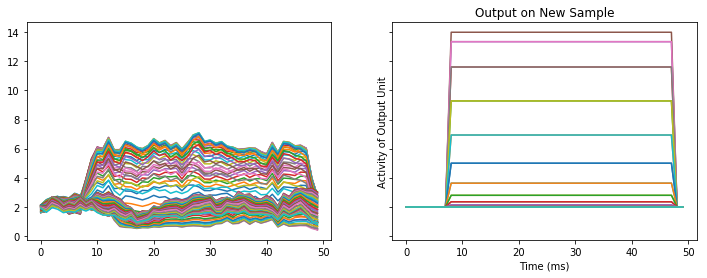

In [474]:
f,ax = plt.subplots(1,2,figsize = (12,4),sharey = True, sharex = True)
ax[0].plot(range(0, len(output[0,:,:])*dt,dt),output[0,:,:]);
plt.ylabel("Activity of Output Unit")
plt.xlabel("Time (ms)")
plt.title("Output on New Sample")
ax[1].plot(range(0, len(y[0,:,:])*dt,dt), y[0,:,:]);

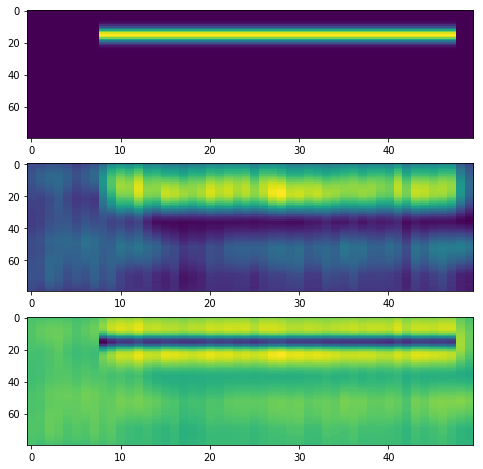

In [475]:
f,ax = plt.subplots(3,1,figsize = (8,8))
ax[0].imshow(y[0,:,:].T,aspect = 'auto');
ax[1].imshow(output[0,:,:].T,aspect = 'auto');
ax[2].imshow(output[0,:,:].T-y[0,:,:].T,aspect = 'auto');

In [476]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

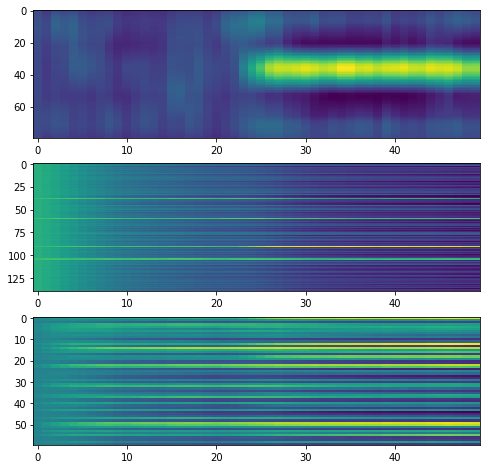

In [477]:
i = 19
f,ax = plt.subplots(3,1,figsize = (8,8))
ax[0].imshow(output[i,:,:].T,aspect = 'auto');
ax[1].imshow(state_var[i,:,E],aspect = 'auto');
ax[2].imshow(state_var[i,:,I],aspect = 'auto');

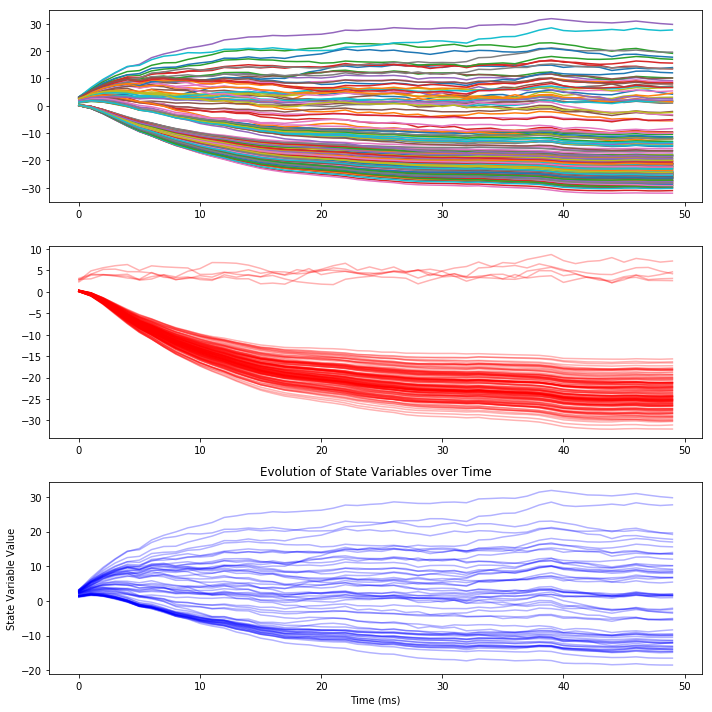

In [478]:
i = 8
f,ax = plt.subplots(3,1,figsize = (10,10))

ax[0].plot(range(0, len(state_var[i,:,:])*dt,dt),state_var[i,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

In [479]:
weights['input_connectivity'].shape

(200, 80)

In [480]:
weights.keys()
toplot = ['W_in', 'W_rec', 
 'W_out','Dale_rec', 
 'Dale_out', 'input_connectivity', 
 'rec_connectivity', 'output_connectivity']

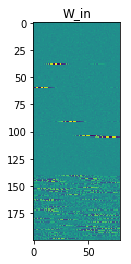

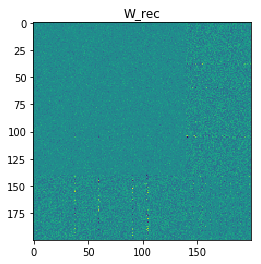

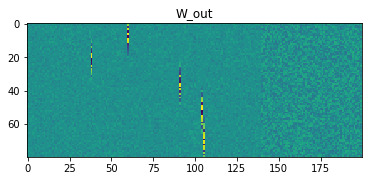

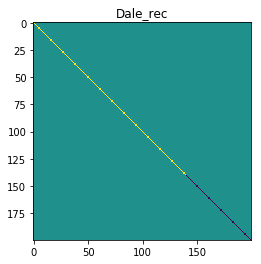

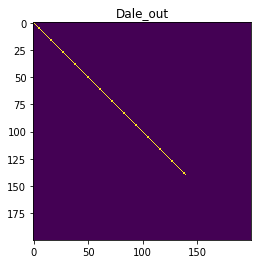

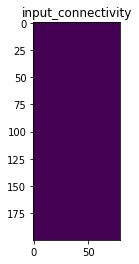

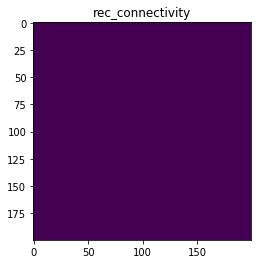

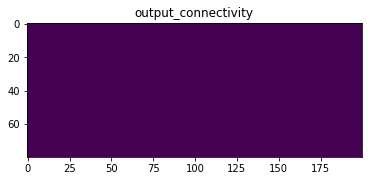

In [481]:
for key in toplot:
    plt.figure()
    plt.imshow(weights[key])
    plt.title(key)

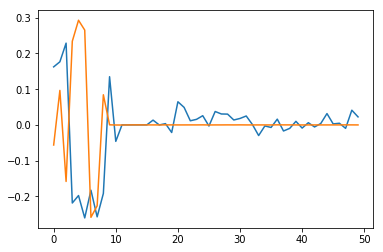

In [341]:
i = 8
plt.plot(weights['W_in'][i,:])
plt.plot(weights['W_out'][:,i])

In [63]:
N_rec = 10
dale_ratio = 0.8

In [64]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [65]:
dale_rec

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

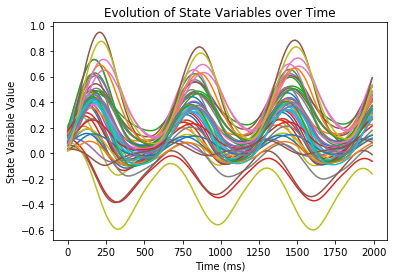

Clean up the model to clear out the tensorflow namespace

In [122]:
basicModel.destruct()

In [ ]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)